In [1]:
#numpy is numerical python, which lets us do math!
import numpy as np
#pandas is for reading in and manipulating dataframe
import pandas as pd
#matplotlib is a plotting library the originated in matlab
from matplotlib import pyplot as plt
#seaborn wraps around matplotlib so that we can make pretty plots more easliy
import seaborn as sns
#this little line of code lets us see the plots in the notebook
%matplotlib inline
#this uses seaborn (sns) to set the style for all the plots
sns.set(context='paper', style='ticks', font_scale=1.2)

#less important for plotting
from glob import glob
from os.path import join
import statsmodels.formula.api as sm
from sklearn.linear_model import LinearRegression
import scipy, scipy.stats
from statsmodels.sandbox.stats.multicomp import multipletests

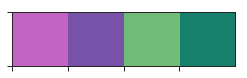

In [2]:
l_purp = '#c364c5'
d_purp = '#7851a9'
l_green = '#71bc78'
d_green = '#17806d'

crayons = [l_purp, d_purp, l_green, d_green]
crayons_l = [crayons[0], crayons[2]]
crayons_d = [crayons[1], crayons[3]]
sns.palplot(sns.color_palette(crayons))

genders = [(0.812, 0.20, 0.551), 
           (0.349, 0.416, 1)]
genders_l = [(0.961, 0.282, 0.676),
             (0.482, 0.529, 1)]

f = [d_purp, l_purp]
m = [d_green, l_green]

In [3]:
def calculate_pvalues(df):
    from scipy.stats import pearsonr
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    rvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            rvalues[r][c] = round(pearsonr(df[r], df[c])[0], 4)
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return rvalues, pvalues

In [4]:
def jili_sidak_mc(data, alpha):
    import math
    import numpy as np

    mc_corrmat = data.corr()
    eigvals, eigvecs = np.linalg.eig(mc_corrmat)

    M_eff = 0
    for eigval in eigvals:
        if abs(eigval) >= 0:
            if abs(eigval) >= 1:
                M_eff += 1
            else:
                M_eff += abs(eigval) - math.floor(abs(eigval))
        else:
            M_eff += 0
    print('Number of effective comparisons: {0}'.format(M_eff))

    #and now applying M_eff to the Sidak procedure
    sidak_p = 1 - (1 - alpha)**(1/M_eff)
    if sidak_p < 0.00001:
        print('Critical value of {:.3f}'.format(alpha),'becomes {:2e} after corrections'.format(sidak_p))
    else:
        print('Critical value of {:.3f}'.format(alpha),'becomes {:.6f} after corrections'.format(sidak_p))
    return sidak_p, M_eff

In [5]:
data_dir = '/Users/Katie/Dropbox/Projects/physics-anxiety/anxiety_results/Results_06-11-18 copy/'
fig_dir = '/Volumes/GoogleDrive/My Drive/salience-anxiety-graph-theory/figures/'
print(join(data_dir, 'All data_6-11-18.xlsx'))

/Users/Katie/Dropbox/Projects/physics-anxiety/anxiety_results/Results_06-11-18 copy/All data_6-11-18.xlsx


In [6]:
df = pd.read_csv('/Users/Katie/Dropbox/Projects/physics-anxiety/anxiety_results/Results_06-11-18 copy/All-data_6-11-18.csv', index_col=0, header=0)

In [7]:
male_df_nofreshmen = pd.read_csv(join(data_dir, 'Male_alldata_06-26-18_no_freshmen.csv'))
female_df_nofreshmen = pd.read_csv(join(data_dir, 'Female_all_data_06-06-18_no freshmen.csv'))

In [8]:
df = df.replace({'Gender': {2: 'Female'}})
df = df.replace({'Gender': {1: 'Male'}})

In [9]:
pre_conn_df = pd.read_csv('/Users/Katie/Dropbox/Projects/physics-anxiety/data/pre_intranetwork_connectivity.csv', 
                          index_col=0, header=0)
post_conn_df = pd.read_csv('/Users/Katie/Dropbox/Projects/physics-anxiety/data/post_intranetwork_connectivity.csv',
                           index_col=0, header=0)
for col in pre_conn_df.columns:
    pre_conn_df.rename({col: '{0} pre'.format(col)}, axis=1, inplace=True)
    post_conn_df.rename({col: '{0} post'.format(col)}, axis=1, inplace=True)

pre_conn_df.drop(['cerebellum pre', 'medial visual pre', 'motor learning pre', 'mouth pre', 'hunger pre', 
                  'orbitofrontal pre', 'auditory pre', 'lateral visual pre', 'hand pre',  'frontoparietal pre', 
                  'limbic pre', 'motor execution pre', 'higher order visual pre', 'basal ganglia pre'], 
                 axis=1, inplace=True)

post_conn_df.drop(['cerebellum post', 'medial visual post', 'motor learning post', 'mouth post', 'hunger post', 
                  'orbitofrontal post', 'auditory post', 'lateral visual post', 'hand post',  'frontoparietal post', 
                  'limbic post', 'motor execution post', 'higher order visual post', 'basal ganglia post'], 
                 axis=1, inplace=True)

pre_conn_df.rename({'right central executive pre': 'central executive pre'}, axis=1, inplace=True)
post_conn_df.rename({'right central executive post': 'central executive post'}, axis=1, inplace=True)

intrantwk_conn_df = pd.concat([pre_conn_df, post_conn_df], axis=1)

In [10]:
intrantwk_conn_df['SN_diff'] = intrantwk_conn_df['salience post'] - intrantwk_conn_df['salience pre']
intrantwk_conn_df['DMN_diff'] = intrantwk_conn_df['default mode post'] - intrantwk_conn_df['default mode pre']
intrantwk_conn_df['CEN_diff'] = intrantwk_conn_df['central executive post'] - intrantwk_conn_df['central executive pre']

In [11]:
intrantwk_conn_df.drop(453, axis=0, inplace=True)

In [12]:
df = pd.concat([df, intrantwk_conn_df], axis=1)

In [13]:
df_f = df[df['Gender'] == 'Female']
df_m = df[df['Gender'] == 'Male']

In [14]:
#melt the anxieties so I can run rmcorr on them
sna_long = df.melt(id_vars='Physics_ID', value_vars=['Pre_SNA_raw', 'Post_SNA_raw'], value_name='Spatial Navigation Anxiety')
sna_long.replace({'Pre_SNA_raw': 'pre', 'Post_SNA_raw': 'post'}, inplace=True)
sna_long.set_index(['Physics_ID', 'variable'], inplace=True)

bk_long = df.melt(id_vars='Physics_ID', value_vars=['Pre_BK_raw', 'Post_BK_raw'], value_name='Clinical Anxiety')
bk_long.replace({'Pre_BK_raw': 'pre', 'Post_BK_raw': 'post'}, inplace=True)
bk_long.set_index(['Physics_ID', 'variable'], inplace=True)

sca_long = df.melt(id_vars='Physics_ID', value_vars=['Pre_ScA_raw', 'Post_ScA_raw'], value_name='Science Anxiety')
sca_long.replace({'Pre_ScA_raw': 'pre', 'Post_ScA_raw': 'post'}, inplace=True)
sca_long.set_index(['Physics_ID', 'variable'], inplace=True)

ma_long = df.melt(id_vars='Physics_ID', value_vars=['Pre_MA_raw', 'Post_MA_raw'], value_name='Math Anxiety')
ma_long.replace({'Pre_MA_raw': 'pre', 'Post_MA_raw': 'post'}, inplace=True)
ma_long.set_index(['Physics_ID', 'variable'], inplace=True)

#and melt the internetwork connections, too
dmnsn_long = df.melt(id_vars='Physics_ID', value_vars=['Pre_DMN_SN', 'Post_DMN_SN'], value_name='DMN_SN')
dmnsn_long.replace({'Pre_DMN_SN': 'pre', 'Post_DMN_SN': 'post'}, inplace=True)
dmnsn_long.set_index(['Physics_ID', 'variable'], inplace=True)

cendmn_long = df.melt(id_vars='Physics_ID', value_vars=['Pre_CEN_DMN', 'Post_CEN_DMN'], value_name='CEN_DMN')
cendmn_long.replace({'Pre_CEN_DMN': 'pre', 'Post_CEN_DMN': 'post'}, inplace=True)
cendmn_long.set_index(['Physics_ID', 'variable'], inplace=True)

sncen_long = df.melt(id_vars='Physics_ID', value_vars=['Pre_SN_CEN', 'Post_SN_CEN'], value_name='SN_CEN')
sncen_long.replace({'Pre_SN_CEN': 'pre', 'Post_SN_CEN': 'post'}, inplace=True)
sncen_long.set_index(['Physics_ID', 'variable'], inplace=True)

long_brainanx = pd.concat((sna_long, bk_long, sca_long, ma_long, 
                           dmnsn_long, cendmn_long, sncen_long), axis=1)
#long_brainanx.to_csv(join(data_dir, 'long_brain_anxiety.csv'))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [15]:
df.rename({'ScA_diff': 'Science Anxiety', 
           'SNA_diff': 'Spatial Navigation Anxiety', 
           'MA_diff': 'Math Anxiety', 
           'BK_diff': 'Clinical Anxiety',
           'CEN_DMN_diff': 'CEN-DMN', 
           'DMN_SN_diff': 'DMN-SN', 
           'SN_CEN_diff': 'SN-CEN',
           'Gender': 'Sex'}, axis=1, inplace=True)

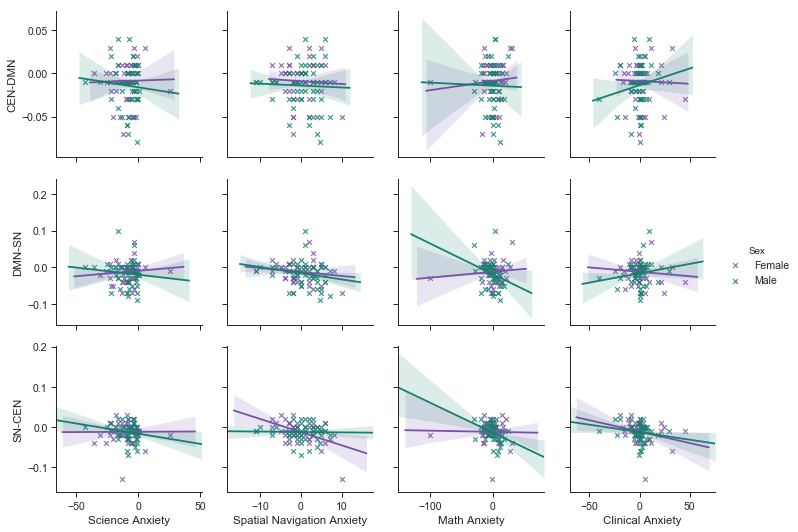

In [16]:
sns.pairplot(data=df, x_vars=['Science Anxiety',
                              'Spatial Navigation Anxiety',
                              'Math Anxiety',
                              'Clinical Anxiety'], 
             y_vars=['CEN-DMN',
                     'DMN-SN',
                     'SN-CEN'], 
             kind='reg', markers='x', hue='Sex', 
             palette=crayons_d, ).savefig(join(fig_dir, 'brain-anx-change-both.png'), dpi=300)

In [17]:
#melt the anxieties so I can run rmcorr on them
sna_long = df_f.melt(id_vars='Physics_ID', value_vars=['Pre_SNA_raw', 'Post_SNA_raw'], value_name='Spatial Navigation Anxiety')
sna_long.replace({'Pre_SNA_raw': 'pre', 'Post_SNA_raw': 'post'}, inplace=True)
sna_long.set_index(['Physics_ID', 'variable'], inplace=True)

bk_long = df_f.melt(id_vars='Physics_ID', value_vars=['Pre_BK_raw', 'Post_BK_raw'], value_name='Clinical Anxiety')
bk_long.replace({'Pre_BK_raw': 'pre', 'Post_BK_raw': 'post'}, inplace=True)
bk_long.set_index(['Physics_ID', 'variable'], inplace=True)

sca_long = df_f.melt(id_vars='Physics_ID', value_vars=['Pre_ScA_raw', 'Post_ScA_raw'], value_name='Science Anxiety')
sca_long.replace({'Pre_ScA_raw': 'pre', 'Post_ScA_raw': 'post'}, inplace=True)
sca_long.set_index(['Physics_ID', 'variable'], inplace=True)

ma_long = df_f.melt(id_vars='Physics_ID', value_vars=['Pre_MA_raw', 'Post_MA_raw'], value_name='Math Anxiety')
ma_long.replace({'Pre_MA_raw': 'pre', 'Post_MA_raw': 'post'}, inplace=True)
ma_long.set_index(['Physics_ID', 'variable'], inplace=True)

#and melt the internetwork connections, too
dmnsn_long = df_f.melt(id_vars='Physics_ID', value_vars=['Pre_DMN_SN', 'Post_DMN_SN'], value_name='DMN_SN')
dmnsn_long.replace({'Pre_DMN_SN': 'pre', 'Post_DMN_SN': 'post'}, inplace=True)
dmnsn_long.set_index(['Physics_ID', 'variable'], inplace=True)

cendmn_long = df_f.melt(id_vars='Physics_ID', value_vars=['Pre_CEN_DMN', 'Post_CEN_DMN'], value_name='CEN_DMN')
cendmn_long.replace({'Pre_CEN_DMN': 'pre', 'Post_CEN_DMN': 'post'}, inplace=True)
cendmn_long.set_index(['Physics_ID', 'variable'], inplace=True)

sncen_long = df_f.melt(id_vars='Physics_ID', value_vars=['Pre_SN_CEN', 'Post_SN_CEN'], value_name='SN_CEN')
sncen_long.replace({'Pre_SN_CEN': 'pre', 'Post_SN_CEN': 'post'}, inplace=True)
sncen_long.set_index(['Physics_ID', 'variable'], inplace=True)

long_brainanx = pd.concat((sna_long, bk_long, sca_long, ma_long, 
                           dmnsn_long, cendmn_long, sncen_long), axis=1)
long_brainanx.to_csv(join(data_dir, 'long_brain_anxiety-female.csv'))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


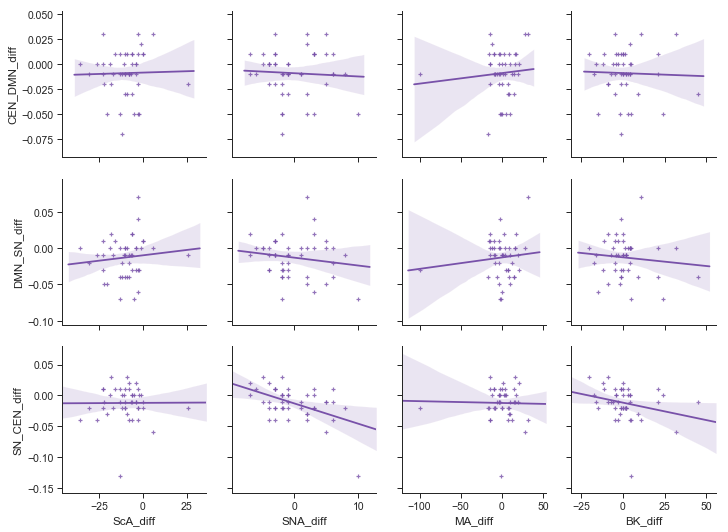

In [18]:
sns.set_palette(f, n_colors=1)
long_brainanx = pd.read_csv(join(data_dir, 'long_brain_anxiety-female.csv'), header=0, index_col=0)
long_brainanx.head()
sns.pairplot(data=df_f, x_vars=['ScA_diff', 'SNA_diff', 'MA_diff', 'BK_diff'], 
             y_vars=['CEN_DMN_diff', 'DMN_SN_diff', 'SN_CEN_diff'], kind='reg', 
             markers='+').savefig(join(fig_dir, 'brain-anx-change-female.png'), dpi=300)

In [19]:
#melt the anxieties so I can run rmcorr on them
sna_long = df_m.melt(id_vars='Physics_ID', value_vars=['Pre_SNA_raw', 'Post_SNA_raw'], value_name='Spatial Navigation Anxiety')
sna_long.replace({'Pre_SNA_raw': 'pre', 'Post_SNA_raw': 'post'}, inplace=True)
sna_long.set_index(['Physics_ID', 'variable'], inplace=True)

bk_long = df_m.melt(id_vars='Physics_ID', value_vars=['Pre_BK_raw', 'Post_BK_raw'], value_name='Clinical Anxiety')
bk_long.replace({'Pre_BK_raw': 'pre', 'Post_BK_raw': 'post'}, inplace=True)
bk_long.set_index(['Physics_ID', 'variable'], inplace=True)

sca_long = df_m.melt(id_vars='Physics_ID', value_vars=['Pre_ScA_raw', 'Post_ScA_raw'], value_name='Science Anxiety')
sca_long.replace({'Pre_ScA_raw': 'pre', 'Post_ScA_raw': 'post'}, inplace=True)
sca_long.set_index(['Physics_ID', 'variable'], inplace=True)

ma_long = df_m.melt(id_vars='Physics_ID', value_vars=['Pre_MA_raw', 'Post_MA_raw'], value_name='Math Anxiety')
ma_long.replace({'Pre_MA_raw': 'pre', 'Post_MA_raw': 'post'}, inplace=True)
ma_long.set_index(['Physics_ID', 'variable'], inplace=True)

#and melt the internetwork connections, too
dmnsn_long = df_m.melt(id_vars='Physics_ID', value_vars=['Pre_DMN_SN', 'Post_DMN_SN'], value_name='DMN_SN')
dmnsn_long.replace({'Pre_DMN_SN': 'pre', 'Post_DMN_SN': 'post'}, inplace=True)
dmnsn_long.set_index(['Physics_ID', 'variable'], inplace=True)

cendmn_long = df_m.melt(id_vars='Physics_ID', value_vars=['Pre_CEN_DMN', 'Post_CEN_DMN'], value_name='CEN_DMN')
cendmn_long.replace({'Pre_CEN_DMN': 'pre', 'Post_CEN_DMN': 'post'}, inplace=True)
cendmn_long.set_index(['Physics_ID', 'variable'], inplace=True)

sncen_long = df_m.melt(id_vars='Physics_ID', value_vars=['Pre_SN_CEN', 'Post_SN_CEN'], value_name='SN_CEN')
sncen_long.replace({'Pre_SN_CEN': 'pre', 'Post_SN_CEN': 'post'}, inplace=True)
sncen_long.set_index(['Physics_ID', 'variable'], inplace=True)

long_brainanx = pd.concat((sna_long, bk_long, sca_long, ma_long, 
                           dmnsn_long, cendmn_long, sncen_long), axis=1)
long_brainanx.to_csv(join(data_dir, 'long_brain_anxiety-male.csv'))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


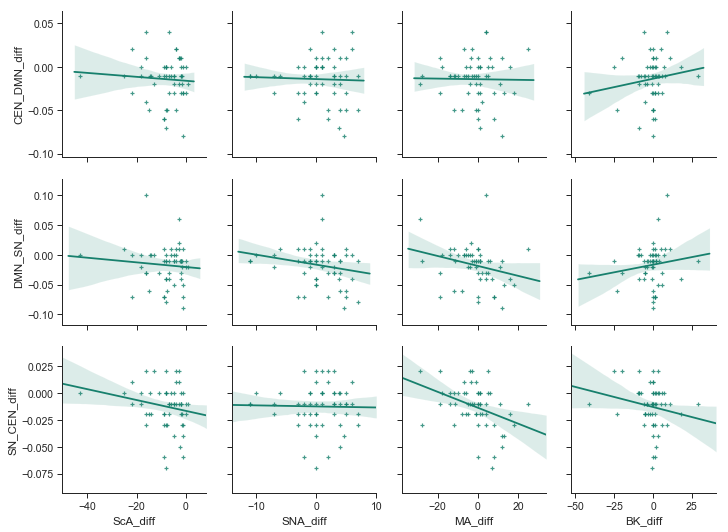

In [20]:
sns.set_palette(m, n_colors=1)
long_brainanx = pd.read_csv(join(data_dir, 'long_brain_anxiety-male.csv'), header=0, index_col=0)
long_brainanx.head()
sns.pairplot(data=df_m, x_vars=['ScA_diff', 'SNA_diff', 'MA_diff', 'BK_diff'], 
             y_vars=['CEN_DMN_diff', 'DMN_SN_diff', 'SN_CEN_diff'], kind='reg', markers='+', 
             palette=m).savefig(join(fig_dir, 'brain-anx-change-male.png'), dpi=300)

In [21]:
kurtosis = df.kurtosis(axis=0, skipna=True)
mean = df.mean(axis=0, skipna=True)
skew = df.skew(axis=0, skipna=True)
median = df.median(axis=0, skipna=True)
stdev = df.std(axis=0, skipna=True)
descriptives = pd.concat([mean, stdev, median, skew, kurtosis], axis=1)
#descriptives.to_csv('{0}/pre-descriptives.csv'.format(data_dir), sep=',')

In [22]:
pre_anx = ['Pre_SNA', 'Pre_BK', 'Pre_ScA', 'Pre_MA']
post_anx = ['Post_BK', 'Post_ScA', 'Post_MA']
pre_intra = ['default mode pre', 'salience pre', 'central executive pre']
post_intra = ['default mode post', 'salience post', 'central executive post']
pre_inter = ['Pre_CEN_DMN', 'Pre_DMN_SN', 'Pre_SN_CEN']
post_inter = ['Post_CEN_DMN', 'Post_SN_CEN', 'Post_DMN_SN']

In [23]:
print('pre anxieties', jili_sidak_mc(df_f[pre_anx], 0.05))
print('post anxieties', jili_sidak_mc(df_f[post_anx], 0.05))
print('pre internetwork', jili_sidak_mc(df_f[pre_inter], 0.05))
print('post internetwork', jili_sidak_mc(df_f[post_inter], 0.05))
print('pre intranetwork', jili_sidak_mc(df_f[pre_intra], 0.05))
print('post intranetwork', jili_sidak_mc(df_f[post_intra], 0.05))

Number of effective comparisons: 3.1882065521557683
Critical value of 0.050 becomes 0.015960 after corrections
pre anxieties (0.015959719898442914, 3.1882065521557683)
Number of effective comparisons: 2.0872481411681045
Critical value of 0.050 becomes 0.024275 after corrections
post anxieties (0.02427510578055725, 2.0872481411681045)
Number of effective comparisons: 1.9835057102981126
Critical value of 0.050 becomes 0.025528 after corrections
pre internetwork (0.025528413711981557, 1.9835057102981126)
Number of effective comparisons: 1.9716996058323235
Critical value of 0.050 becomes 0.025679 after corrections
post internetwork (0.025679292632165174, 1.9716996058323235)
Number of effective comparisons: 2.5855221504744197
Critical value of 0.050 becomes 0.019643 after corrections
pre intranetwork (0.019643168499717145, 2.5855221504744197)
Number of effective comparisons: 2.931881153308884
Critical value of 0.050 becomes 0.017343 after corrections
post intranetwork (0.017342862326421016,

In [24]:
pre_anx_inter = pre_anx + pre_inter
post_anx_inter = post_anx + post_inter
pre = pre_anx + pre_inter + pre_intra
post = post_anx + post_inter + post_intra
pre_anx_intra = pre_anx + pre_intra
post_anx_intra = post_anx + post_intra

In [25]:
pre_f_anxinter_mc = jili_sidak_mc(df_f[pre_anx], 0.05)
post_f_anxinter_mc = jili_sidak_mc(df_f[post_anx], 0.05)
pre_f_anxintra_mc = jili_sidak_mc(df_f[pre_anx], 0.05)
post_f_anxintra_mc = jili_sidak_mc(df_f[post_anx], 0.05)

pre_f_brainanx_r = calculate_pvalues(df_f[pre])[0]
pre_f_brainanx_p = calculate_pvalues(df_f[pre])[1]
post_f_brainanx_r = calculate_pvalues(df_f[post])[0]
post_f_brainanx_p = calculate_pvalues(df_f[post])[1]


print('\nPre, female students, internetwork and anxiety, adjusted alpha of {0}:'.format(np.round(pre_f_anxinter_mc[0],4)))
for key1 in pre_anx:
    for key2 in pre_inter:
        if key1 != key2:
            if pre_f_brainanx_p[key1][key2] < pre_f_anxinter_mc[0]:
                print('{0} corr with {1}'.format(key1,key2), 
                      pre_f_brainanx_r[key1][key2], 
                      pre_f_brainanx_p[key1][key2])
                
print('\nPost, female students, internetwork and anxiety, adjusted alpha of {0}:'.format(np.round(post_f_anxinter_mc[0],4)))
for key1 in post_anx:
    for key2 in post_inter:
        if key1 != key2:
            if post_f_brainanx_p[key1][key2] < post_f_anxinter_mc[0]:
                print('{0} corr with {1}'.format(key1,key2), 
                      post_f_brainanx_r[key1][key2], 
                      post_f_brainanx_p[key1][key2])
                
print('\nPre, female students, intranetwork and anxiety, adjusted alpha of {0}:'.format(np.round(pre_f_anxintra_mc[0],4)))
for key1 in pre_anx:
    for key2 in pre_intra:
        if key1 != key2:
            if pre_f_brainanx_p[key1][key2] < pre_f_anxintra_mc[0]:
                print('{0} corr with {1}'.format(key1,key2), 
                      pre_f_brainanx_r[key1][key2], 
                      pre_f_brainanx_p[key1][key2])

print('\nPost, female students, intranetwork and anxiety, adjusted alpha of {0}:'.format(np.round(post_f_anxintra_mc[0],4)))
for key1 in post_anx:
    for key2 in post_intra:
        if key1 != key2:
            if post_f_brainanx_p[key1][key2] < post_f_anxintra_mc[0]:
                print('{0} corr with {1}'.format(key1,key2), 
                      post_f_brainanx_r[key1][key2], 
                      post_f_brainanx_p[key1][key2])

Number of effective comparisons: 3.1882065521557683
Critical value of 0.050 becomes 0.015960 after corrections
Number of effective comparisons: 2.0872481411681045
Critical value of 0.050 becomes 0.024275 after corrections
Number of effective comparisons: 3.1882065521557683
Critical value of 0.050 becomes 0.015960 after corrections
Number of effective comparisons: 2.0872481411681045
Critical value of 0.050 becomes 0.024275 after corrections

Pre, female students, internetwork and anxiety, adjusted alpha of 0.016:

Post, female students, internetwork and anxiety, adjusted alpha of 0.0243:

Pre, female students, intranetwork and anxiety, adjusted alpha of 0.016:

Post, female students, intranetwork and anxiety, adjusted alpha of 0.0243:


In [26]:
all_mc = jili_sidak_mc(df[pre+post], 0.05)
all_brainanx_p = calculate_pvalues(df[pre+post])[1]
#f_anxinter_mc = jili_sidak_mc(df_f[pre_anx+post_anx], 0.05)

Number of effective comparisons: 11.556201120144063
Critical value of 0.050 becomes 0.004429 after corrections


In [27]:
all_brainanx_p.index

Index(['Pre_SNA', 'Pre_BK', 'Pre_ScA', 'Pre_MA', 'Pre_CEN_DMN', 'Pre_DMN_SN',
       'Pre_SN_CEN', 'default mode pre', 'salience pre',
       'central executive pre', 'Post_BK', 'Post_ScA', 'Post_MA',
       'Post_CEN_DMN', 'Post_SN_CEN', 'Post_DMN_SN', 'default mode post',
       'salience post', 'central executive post'],
      dtype='object')

In [28]:
from statsmodels.stats.multitest import multipletests
k = multipletests(np.ravel(all_brainanx_p, order='C'), alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
pass_test = pd.DataFrame(k[0].reshape(19,19), index=all_brainanx_p.index, columns=all_brainanx_p.columns)

In [29]:
pass_test

,Pre_SNA,Pre_BK,Pre_ScA,Pre_MA,Pre_CEN_DMN,Pre_DMN_SN,Pre_SN_CEN,default mode pre,salience pre,central executive pre,Post_BK,Post_ScA,Post_MA,Post_CEN_DMN,Post_SN_CEN,Post_DMN_SN,default mode post,salience post,central executive post
Pre_SNA,True,False,True,True,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False
Pre_BK,False,True,True,True,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False
Pre_ScA,True,True,True,True,False,True,False,False,False,False,True,True,True,False,False,True,False,False,False
Pre_MA,True,True,True,True,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False
Pre_CEN_DMN,False,False,False,False,True,True,False,False,False,True,False,False,False,True,False,True,False,False,False
Pre_DMN_SN,False,False,True,False,True,True,True,False,False,True,False,False,False,True,True,True,False,False,True
Pre_SN_CEN,False,False,False,False,False,True,True,False,True,False,False,False,False,False,True,True,False,False,False
default mode pre,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False
salience pre,False,False,False,False,False,False,True,False,True,False,False,False,False,False,True,False,False,True,False
central executive pre,False,False,False,False,True,True,False,False,False,True,False,False,False,True,False,True,False,False,True


In [30]:
pre_m_anxinter_mc = jili_sidak_mc(df_m[pre_anx], 0.05)
post_m_anxinter_mc = jili_sidak_mc(df_m[post_anx], 0.05)
pre_m_anxintra_mc = jili_sidak_mc(df_m[pre_anx], 0.05)
post_m_anxintra_mc = jili_sidak_mc(df_m[post_anx], 0.05)

pre_m_brainanx_r = calculate_pvalues(df_m[pre])[0]
pre_m_brainanx_p = calculate_pvalues(df_m[pre])[1]
post_m_brainanx_r = calculate_pvalues(df_m[post])[0]
post_m_brainanx_p = calculate_pvalues(df_m[post])[1]

print('\nPre, male students, internetwork and anxiety, adjusted alpha of {0}:'.format(np.round(pre_m_anxinter_mc[0],4)))
for key1 in pre_anx:
    for key2 in pre_inter:
        if key1 != key2:
            if pre_m_brainanx_p[key1][key2] < pre_m_anxinter_mc[0]:
                print('{0} corr with {1}'.format(key1,key2), 
                      pre_m_brainanx_r[key1][key2], 
                      pre_m_brainanx_p[key1][key2])

print('\nPost, male students, internetwork and anxiety, adjusted alpha of {0}:'.format(np.round(post_m_anxinter_mc[0],4)))
for key1 in post_anx:
    for key2 in post_inter:
        if key1 != key2:
            if post_m_brainanx_p[key1][key2] < post_m_anxinter_mc[0]:
                print('{0} corr with {1}'.format(key1,key2), 
                      post_m_brainanx_r[key1][key2], 
                      post_m_brainanx_p[key1][key2])
print('\nPre, male students, intranetwork and anxiety, adjusted alpha of {0}:'.format(np.round(pre_m_anxintra_mc[0],4)))          
for key1 in pre_anx:
    for key2 in pre_intra:
        if key1 != key2:
            if pre_m_brainanx_p[key1][key2] < pre_m_anxintra_mc[0]:
                print('{0} corr with {1}'.format(key1,key2), 
                      pre_m_brainanx_r[key1][key2], 
                      pre_m_brainanx_p[key1][key2])
                
            
print('\nPost, male students, intranetwork and anxiety, adjusted alpha of {0}:'.format(np.round(post_m_anxintra_mc[0],4)))
for key1 in post_anx:
    for key2 in post_intra:
        if key1 != key2:
            if post_m_brainanx_p[key1][key2] < post_m_anxintra_mc[0]:
                print('{0} corr with {1}'.format(key1,key2), 
                      post_m_brainanx_r[key1][key2], 
                      post_m_brainanx_p[key1][key2])
            

Number of effective comparisons: 2.7227736331156325
Critical value of 0.050 becomes 0.018662 after corrections
Number of effective comparisons: 2.1503885061334556
Critical value of 0.050 becomes 0.023571 after corrections
Number of effective comparisons: 2.7227736331156325
Critical value of 0.050 becomes 0.018662 after corrections
Number of effective comparisons: 2.1503885061334556
Critical value of 0.050 becomes 0.023571 after corrections

Pre, male students, internetwork and anxiety, adjusted alpha of 0.0187:
Pre_SNA corr with Pre_CEN_DMN 0.3642 0.0063
Pre_BK corr with Pre_SN_CEN -0.342 0.0106
Pre_MA corr with Pre_CEN_DMN 0.3255 0.0153
Pre_MA corr with Pre_DMN_SN 0.3519 0.0084

Post, male students, internetwork and anxiety, adjusted alpha of 0.0236:
Post_MA corr with Post_DMN_SN 0.3306 0.0137

Pre, male students, intranetwork and anxiety, adjusted alpha of 0.0187:

Post, male students, intranetwork and anxiety, adjusted alpha of 0.0236:


In [31]:
delta_anx = ['BK_diff', 'MA_diff', 'ScA_diff', 'SNA_diff']
delta_inter = ['CEN_DMN_diff', 'SN_CEN_diff', 'DMN_SN_diff']
delta_intra = ['SN_diff', 'DMN_diff', 'CEN_diff']
delta_anxinter = delta_anx + delta_inter
delta_anxintra = delta_anx + delta_intra
delta = delta_anx + delta_inter + delta_intra

In [32]:
f_delta_anxintra_mc = jili_sidak_mc(df_f[delta_anx], 0.05)
f_delta_anxinter_mc = jili_sidak_mc(df_f[delta_anx], 0.05)

delta_f_brainanx_r = calculate_pvalues(df_f[delta])[0]
delta_f_brainanx_p = calculate_pvalues(df_f[delta])[1]

print('\n\nFemale students, change in internetwork connectivity and anxiety (post - pre), adjusted alpha of {0}:'.format(np.round(f_delta_anxinter_mc[0],4)))
for key1 in delta_anx:
    for key2 in delta_inter:
        if key1 != key2:
            if delta_f_brainanx_p[key1][key2] < f_delta_anxinter_mc[0]:
                print('{0} corr with {1}'.format(key1,key2), 
                      delta_f_brainanx_r[key1][key2], 
                      delta_f_brainanx_p[key1][key2])

print('\n\nFemale students, change in intranetwork connectivity and anxiety (post - pre), adjusted alpha of {0}:'.format(np.round(f_delta_anxintra_mc[0],4)))
for key1 in delta_anx:
    for key2 in delta_intra:
        if key1 != key2:
            if delta_f_brainanx_p[key1][key2] < f_delta_anxintra_mc[0]:
                print('{0} corr with {1}'.format(key1,key2), 
                      delta_f_brainanx_r[key1][key2], 
                      delta_f_brainanx_p[key1][key2])

Number of effective comparisons: 3.2891101077156897
Critical value of 0.050 becomes 0.015474 after corrections
Number of effective comparisons: 3.2891101077156897
Critical value of 0.050 becomes 0.015474 after corrections


Female students, change in internetwork connectivity and anxiety (post - pre), adjusted alpha of 0.0155:
SNA_diff corr with SN_CEN_diff -0.4998 0.0004


Female students, change in intranetwork connectivity and anxiety (post - pre), adjusted alpha of 0.0155:


In [33]:
m_delta_anxintra_mc = jili_sidak_mc(df_m[delta_anx], 0.05)
m_delta_anxinter_mc = jili_sidak_mc(df_m[delta_anx], 0.05)

delta_m_brainanx_r = calculate_pvalues(df_m[delta])[0]
delta_m_brainanx_p = calculate_pvalues(df_m[delta])[1]

print('\n\nMale students, change in internetwork connectivity and anxiety (post - pre), adjusted alpha of {0}:'.format(np.round(m_delta_anxinter_mc[0], 4)))
for key1 in delta_anx:
    for key2 in delta_inter:
        if key1 != key2:
            if delta_m_brainanx_p[key1][key2] < m_delta_anxinter_mc[0]:
                print('{0} corr with {1}'.format(key1,key2), 
                      delta_m_brainanx_r[key1][key2], 
                      delta_m_brainanx_p[key1][key2])

print('\n\nMale students, change in intranetwork connectivity and anxiety (post - pre), adjusted alpha of {0}:'.format(np.round(m_delta_anxintra_mc[0],4)))
for key1 in delta_anx:
    for key2 in delta_intra:
        if key1 != key2:
            if delta_m_brainanx_p[key1][key2] < m_delta_anxintra_mc[0]:
                print('{0} corr with {1}'.format(key1,key2), 
                      delta_m_brainanx_r[key1][key2], 
                      delta_m_brainanx_p[key1][key2])

Number of effective comparisons: 3.315211829911703
Critical value of 0.050 becomes 0.015353 after corrections
Number of effective comparisons: 3.315211829911703
Critical value of 0.050 becomes 0.015353 after corrections


Male students, change in internetwork connectivity and anxiety (post - pre), adjusted alpha of 0.0154:
MA_diff corr with SN_CEN_diff -0.3843 0.0038


Male students, change in intranetwork connectivity and anxiety (post - pre), adjusted alpha of 0.0154:


In [34]:
pre_post_braincorr = np.empty((3,3), dtype=float)

In [35]:
pre_post_braincorr[0,1] = np.average(df['Pre_DMN_SN'])
pre_post_braincorr[1,0] = np.average(df['Post_DMN_SN'])

pre_post_braincorr[2,0] = np.average(df['Pre_CEN_DMN'])
pre_post_braincorr[0,2] = np.average(df['Post_CEN_DMN'])

pre_post_braincorr[2,1] = np.average(df['Pre_SN_CEN'])
pre_post_braincorr[1,2] = np.average(df['Post_SN_CEN'])

In [36]:
pre_post_braincorr

array([[ 0.        , -0.0470297 ,  0.18019802],
       [-0.03316832,  0.        ,  0.52059406],
       [ 0.1690099 ,  0.50732673,  0.        ]])

In [37]:
corrfonty = {'fontsize': 10,
             'fontweight': 'regular',
             'verticalalignment': 'center',
             'horizontalalignment': 'right'}
corrfontx = {'fontsize': 10,
             'fontweight': 'regular',
             'verticalalignment': 'top',
             'horizontalalignment': 'center'}

[Text(0.5,0,'Default Mode'),
 Text(1.5,0,'Salience'),
 Text(2.5,0,'Central Executive')]

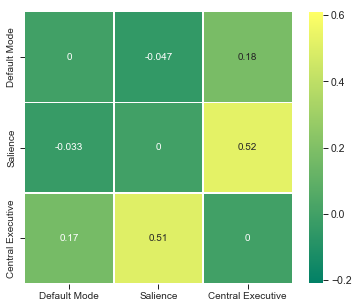

In [38]:
fig,ax = plt.subplots(figsize=(6,5))
ax = sns.heatmap(pre_post_braincorr, annot=True, linewidths=0.5, cmap='summer', vmin=-0.21, vmax=0.61, 
                 cbar_kws={'ticks': [0.6, 0.4, 0.2, 0, -0.2]})
ax.set_yticklabels(['Default Mode', 'Salience', 'Central Executive'], fontdict=corrfonty)
ax.set_xticklabels(['Default Mode', 'Salience', 'Central Executive'], fontdict=corrfontx)
#fig.savefig('/Users/Katie/Dropbox/Projects/physics-anxiety/all-subj-corrmat.png', dpi=300)

In [39]:
df_anx_pre_gender = df.melt(id_vars='Sex', value_vars=['Pre_SNA', 'Pre_BK', 'Pre_ScA', 'Pre_MA'], 
                            var_name='Science_Anxieties_Pre')
df_anx_post_gender = df.melt(id_vars='Sex', value_vars=['Post_SNA', 'Post_BK', 'Post_ScA', 'Post_MA'], 
                            var_name='Science_Anxieties_Post')

## Figure 1: pre < post, science & beck anxiety, women & men
Four anxieties, two swarms per (pre/post), two colors (gender)
<br>
Make a version without the swarms, with a thing instead.

In [40]:
crayons = sns.crayon_palette(['Fuchsia', 'Fern'])
dark_crayons = sns.crayon_palette(['Royal Purple', 'Tropical Rain Forest'])

f = sns.diverging_palette(280.2, 327.8, s=85, l=50, n=200)
m = sns.diverging_palette(200, 263.2, s=85, l=50, n=200)
#royal purple and fuchsia
#tropical rain forest and fern

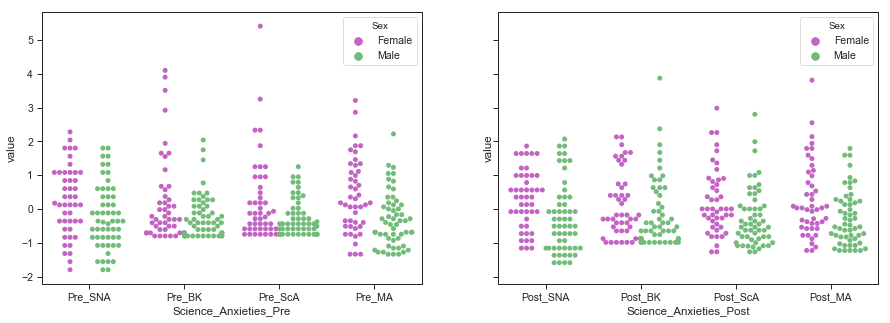

In [41]:
fig, ax = plt.subplots(1, ncols=2, figsize=(15, 5), sharey=True)
g = sns.swarmplot(x="Science_Anxieties_Pre", y="value", hue="Sex", dodge=True, 
                  data=df_anx_pre_gender, palette=crayons_l, size=5, ax=ax[0])
g = sns.swarmplot(x="Science_Anxieties_Post", y="value", hue="Sex", dodge=True, 
                  data=df_anx_post_gender, palette=crayons_l, size=5, ax=ax[1])

In [42]:
#want new df with science anxiety + gender, annotated by pre + post
#############################
###### STD SCORES ###########
#############################
df_sca = df.melt(id_vars='Sex', value_vars=['Pre_ScA', 'Post_ScA'],
                 var_name='Science Anxiety')
df_sca.replace(to_replace='Pre_ScA', value='Pre', inplace=True)
df_sca.replace(to_replace='Post_ScA', value='Post', inplace=True)

#want new df with science anxiety + gender, annotated by pre + post
df_ma = df.melt(id_vars='Sex', value_vars=['Pre_MA', 'Post_MA'],
                 var_name='Math Anxiety')
df_ma.replace(to_replace='Pre_MA', value='Pre', inplace=True)
df_ma.replace(to_replace='Post_MA', value='Post', inplace=True)

#want new df with science anxiety + gender, annotated by pre + post
df_sna = df.melt(id_vars='Sex', value_vars=['Pre_SNA', 'Post_SNA'],
                 var_name='Spatial Navigation Anxiety')
df_sna.replace(to_replace='Pre_SNA', value='Pre', inplace=True)
df_sna.replace(to_replace='Post_SNA', value='Post', inplace=True)

#want new df with science anxiety + gender, annotated by pre + post
df_bk = df.melt(id_vars='Sex', value_vars=['Pre_BK', 'Post_BK'],
                 var_name='Beck Anxiety')
df_bk.replace(to_replace='Pre_BK', value='Pre', inplace=True)
df_bk.replace(to_replace='Post_BK', value='Post', inplace=True)

In [43]:
#want new df with science anxiety + gender, annotated by pre + post
#############################
###### RAW SCORES ###########
#############################
df_sca = df.melt(id_vars='Sex', value_vars=['Pre_ScA_raw', 'Post_ScA_raw'],
                 var_name='Science Anxiety')
df_sca.replace(to_replace='Pre_ScA_raw', value='Pre', inplace=True)
df_sca.replace(to_replace='Post_ScA_raw', value='Post', inplace=True)

#want new df with science anxiety + gender, annotated by pre + post
df_ma = df.melt(id_vars='Sex', value_vars=['Pre_MA_raw', 'Post_MA_raw'],
                 var_name='Math Anxiety')
df_ma.replace(to_replace='Pre_MA_raw', value='Pre', inplace=True)
df_ma.replace(to_replace='Post_MA_raw', value='Post', inplace=True)

#want new df with science anxiety + gender, annotated by pre + post
df_sna = df.melt(id_vars='Sex', value_vars=['Pre_SNA_raw', 'Post_SNA_raw'],
                 var_name='Spatial Navigation Anxiety')
df_sna.replace(to_replace='Pre_SNA_raw', value='Pre', inplace=True)
df_sna.replace(to_replace='Post_SNA_raw', value='Post', inplace=True)

#want new df with science anxiety + gender, annotated by pre + post
df_bk = df.melt(id_vars='Sex', value_vars=['Pre_BK_raw', 'Post_BK_raw'],
                 var_name='Beck Anxiety')
df_bk.replace(to_replace='Pre_BK_raw', value='Pre', inplace=True)
df_bk.replace(to_replace='Post_BK_raw', value='Post', inplace=True)

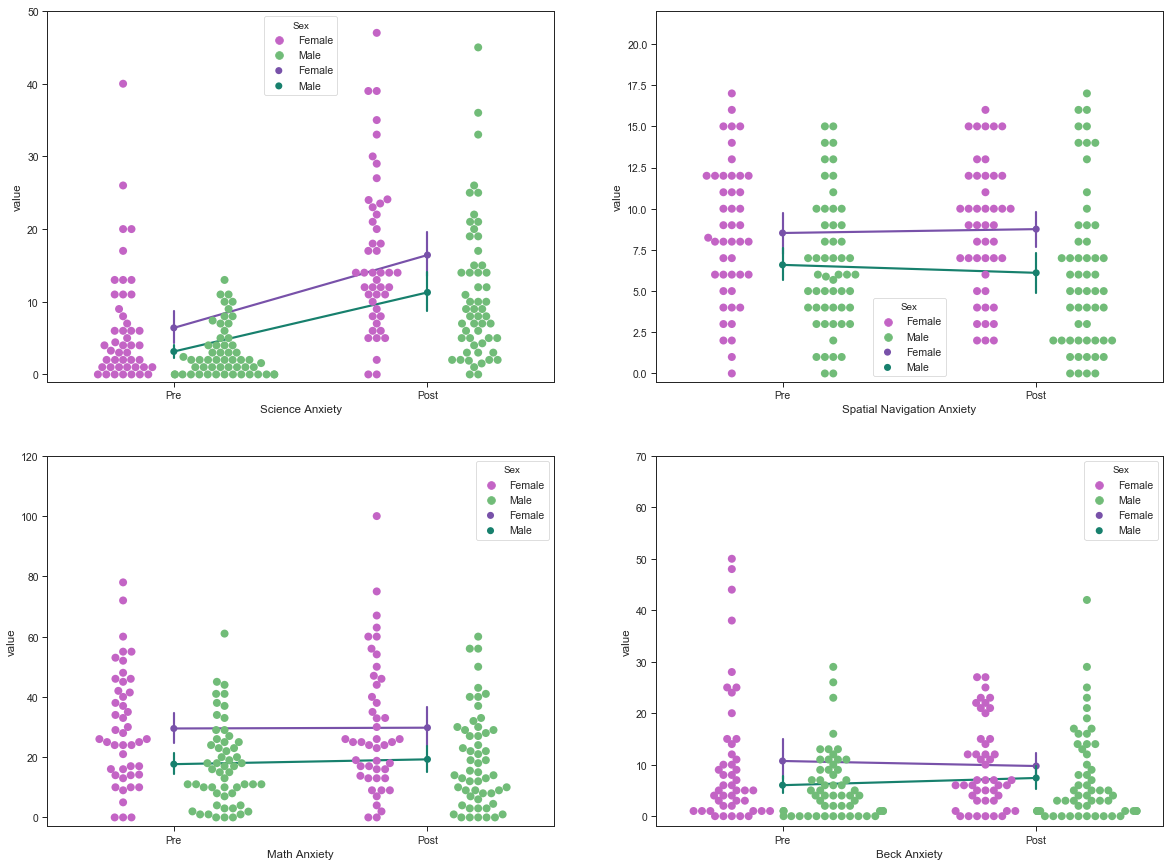

In [44]:
fig,ax = plt.subplots(ncols=2, nrows=2, figsize=(20, 15), sharex=False, sharey=False, squeeze=True)
mksz = 8

sns.swarmplot(x="Science Anxiety", y="value", hue="Sex", data=df_sca, 
              palette=crayons_l, ax=ax[0][0], size=mksz, dodge=True)
ax[0][0].set_ylim(-1,50)
sns.swarmplot(x="Math Anxiety", y="value", hue="Sex", data=df_ma, 
              palette=crayons_l, ax=ax[1][0], size=mksz, dodge=True)
ax[1][0].set_ylim(-3,120)
sns.swarmplot(x="Spatial Navigation Anxiety", y="value", hue="Sex", data=df_sna, 
              palette=crayons_l, ax=ax[0][1], size=mksz, dodge=True)
ax[0][1].set_ylim(-0.5,22)
sns.swarmplot(x="Beck Anxiety", y="value", hue="Sex", data=df_bk, 
              palette=crayons_l, ax=ax[1][1], size=mksz, dodge=True)
ax[1][1].set_ylim(-2,70)

sns.pointplot(x="Science Anxiety", y="value", hue="Sex", data=df_sca, palette=crayons_d, ax=ax[0][0], size=mksz)
sns.pointplot(x="Math Anxiety", y="value", hue="Sex", data=df_ma, palette=crayons_d, ax=ax[1][0], size=mksz)
sns.pointplot(x="Spatial Navigation Anxiety", y="value", hue="Sex", data=df_sna, palette=crayons_d, ax=ax[0][1], size=mksz)
sns.pointplot(x="Beck Anxiety", y="value", hue="Sex", data=df_bk, palette=crayons_d, ax=ax[1][1], size=mksz)

#fig.savefig('/Users/Katie/Dropbox/Projects/physics-anxiety/figures/figure1_rawscores-pg.png', dpi=300)

## Figure 2.  Changes in anxiety correlated with changes in connectivity
Making the glass brains for the figure.

In [45]:
#maybe change to match
f = sns.diverging_palette(306.7, 327.8, s=90, l=45, n=200)
m = sns.diverging_palette(173.4, 263.2, s=90, l=45, n=200)

In [46]:
from nilearn import plotting, datasets, surface
fsaverage = datasets.fetch_surf_fsaverage()

dmn = '/Users/Katie/Dropbox/Katie and Angie/2011 BrainMap ICA Maps/18-network-parcellation/comp13-bin.nii.gz'
cen = '/Users/Katie/Dropbox/Katie and Angie/2011 BrainMap ICA Maps/cen_combo.nii.gz'
sal = '/Users/Katie/Dropbox/Katie and Angie/2011 BrainMap ICA Maps/18-network-parcellation/comp4-bin.nii.gz'

In [47]:
contrast_colors = sns.blend_palette(['#ff4c80', '#00a572'], n_colors=2, as_cmap=True)
color1 = sns.light_palette("#ff467e", as_cmap=True)
color2 = sns.light_palette("#00efd8", as_cmap=True)
color3 = sns.light_palette("#cedf3f", as_cmap=True)

In [48]:
dmn_html = plotting.view_img_on_surf(dmn, threshold=0.9, cmap=color1)
dmn_html.save_as_html('dmn_surf.html')
cen_html = plotting.view_img_on_surf(cen, threshold=0.9, cmap=color2)
cen_html.save_as_html('cen_surf.html')
sal_html = plotting.view_img_on_surf(sal, threshold=0.9, cmap=color3)
sal_html.save_as_html('sal_surf.html')

In [49]:
#making figure 2 heatmaps
fig2_df = df.drop(columns=['Cohort', 'GPA.PreSem', 'Phy48Grade', 'AgeOnScanDate',
                           'Pre_SNA', 'Pre_BK', 'Pre_ScA', 'Pre_MA', 'Pre_STEMcomposite',
                           'Post_SNA', 'Post_BK', 'Post_ScA', 'Post_MA', 'Post_STEMcomposite',
                           'Post_Clustering', 'Pre_Clustering',
                           'Post_Efficiency', 'Pre_Efficiency',
                           'Pre_BK_Sq', 'Post_BK_Sq', 'Pre_SNA_Sq',
                           'Pre_ScA_Sq', 'Post_ScA_Sq', 'Pre_MA_Sq', 'Post_MA_Sq', 
                           'Clustering_diff', 'Efficiency_diff',
                           'filter_$', 'CEN_DMN_diff_male',
                           'Clustering_diff_male', 'DMN_SN_diff_male', 'Efficiency_diff_male',
                           'SN_CEN_diff_male', 'CEN_DMN_diff_female', 'Clustering_diff_female',
                           'DMN_SN_diff_female', 'Efficiency_diff_female', 'SN_CEN_diff_female',
                           'SNA_diff_male_raw', 'BK_diff_male_raw', 'ScA_diff_male_raw',
                           'MA_diff_male_raw', 'SNA_diff_female_raw', 'BK_diff_female_raw',
                           'ScA_diff_female_raw', 'MA_diff_female_raw', 'SNA_diff_male',
                           'BK_diff_male', 'ScA_diff_male', 'MA_diff_male'])

In [50]:
fig2_df.keys()

Index(['Sex', 'Post_CEN_DMN', 'Pre_CEN_DMN', 'Post_DMN_SN', 'Pre_DMN_SN',
       'Post_SN_CEN', 'Pre_SN_CEN', 'Pre_SNA_raw', 'Pre_BK_raw', 'Pre_ScA_raw',
       'Pre_MA_raw', 'Post_BK_raw', 'Post_ScA_raw', 'Post_MA_raw',
       'Post_SNA_raw', 'Clinical Anxiety', 'Math Anxiety', 'CEN-DMN', 'DMN-SN',
       'SN-CEN', 'Science Anxiety', 'Spatial Navigation Anxiety',
       'default mode pre', 'salience pre', 'central executive pre',
       'default mode post', 'salience post', 'central executive post',
       'SN_diff', 'DMN_diff', 'CEN_diff'],
      dtype='object')

In [51]:
m2_df = fig2_df[fig2_df['Sex'] == 'Male']
f2_df = fig2_df[fig2_df['Sex'] == 'Female']

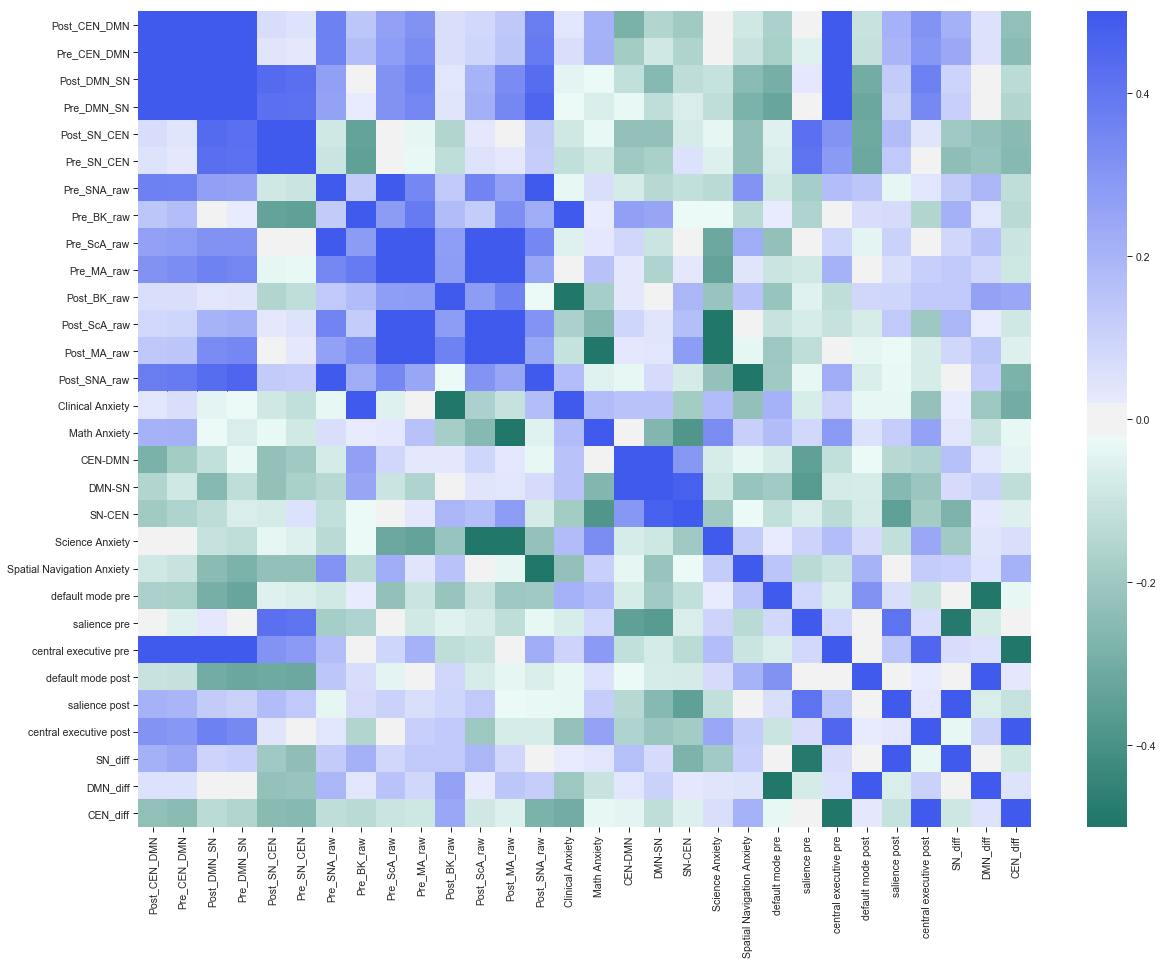

In [52]:
m2_corr = m2_df.corr(method='pearson')
fig,ax = plt.subplots(figsize=(20,15))
ax = sns.heatmap(m2_corr, cmap=m, vmax=0.5, vmin=-0.5)
#fig.savefig('/Volumes/GoogleDrive/My Drive/salience-anxiety-graph-theory/figures/fig2-male.png', dpi=300)

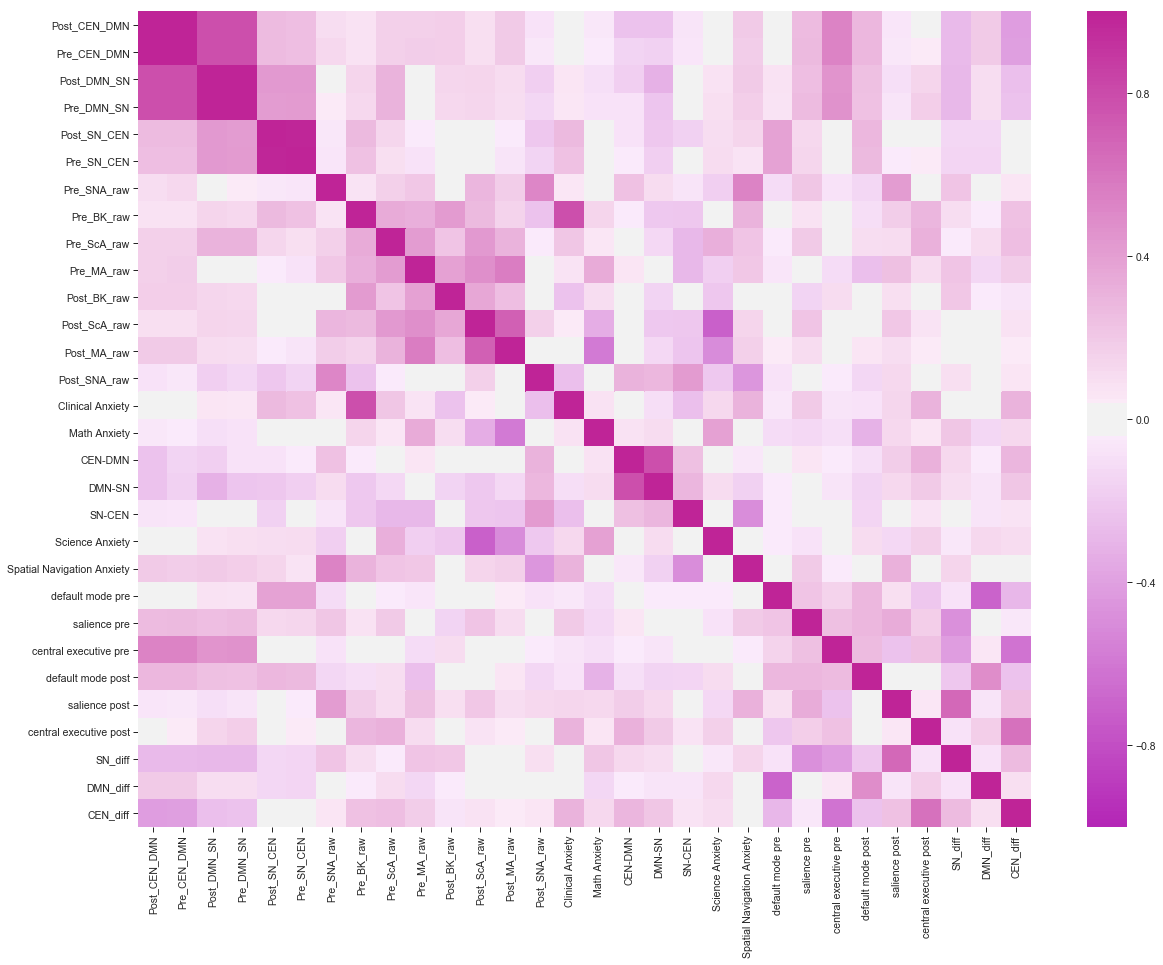

In [53]:
f2_corr = f2_df.corr(method='pearson')
fig,ax = plt.subplots(figsize=(20,15))
ax = sns.heatmap(f2_corr, cmap=f, vmin=-1, vmax=1)
#fig.savefig('/Volumes/GoogleDrive/My Drive/salience-anxiety-graph-theory/figures/fig2-female.png', dpi=300)

## 9/14: exclude freshmen from GPA correlations!!!
Send Angie a no-freshmen GPA corrmat.

In [54]:
#what's the question we're asking? 
#is it "do brain measures contribute to explained vairance in student oucomes by anxiety?" 
#do brain measures explain anxiety?
#do brain measures + anxiety explain poor student outcomes?
#does anxeity explain poor student outcomes?

## Figure 3. Relationships between pre-course anxiety and outcomes

Reviewer wanted to see intranetwork connectivity in relation to anxiety

In [55]:
f_nofresh = female_df_nofreshmen.drop(columns=['Physics_ID', 'Cohort', 'Gender', 'Phy48Grade',
       'AgeOnScanDate',
       'Pre_STEMcomposite',
       'Post_STEMcomposite', 'Post_CEN_DMN', 'Pre_CEN_DMN', 'Post_Clustering',
       'Pre_Clustering', 'Post_DMN_SN', 'Pre_DMN_SN', 'Post_Efficiency',
       'Pre_Efficiency', 'Post_SN_CEN', 'Pre_SN_CEN', 'CEN_DMN_diff', 'Clustering_diff', 'DMN_SN_diff',
       'Efficiency_diff', 'SN_CEN_diff'])

In [56]:
m_nofresh = male_df_nofreshmen.drop(columns=['Physics_ID', 'Cohort', 'Gender', 'Phy48Grade',
       'AgeOnScanDate',
       'Pre_STEMcomposite',
       'Post_STEMcomposite', 'Post_CEN_DMN', 'Pre_CEN_DMN', 'Post_Clustering',
       'Pre_Clustering', 'Post_DMN_SN', 'Pre_DMN_SN', 'Post_Efficiency',
       'Pre_Efficiency', 'Post_SN_CEN', 'Pre_SN_CEN', 'CEN_DMN_diff', 'Clustering_diff', 'DMN_SN_diff',
       'Efficiency_diff', 'SN_CEN_diff'])

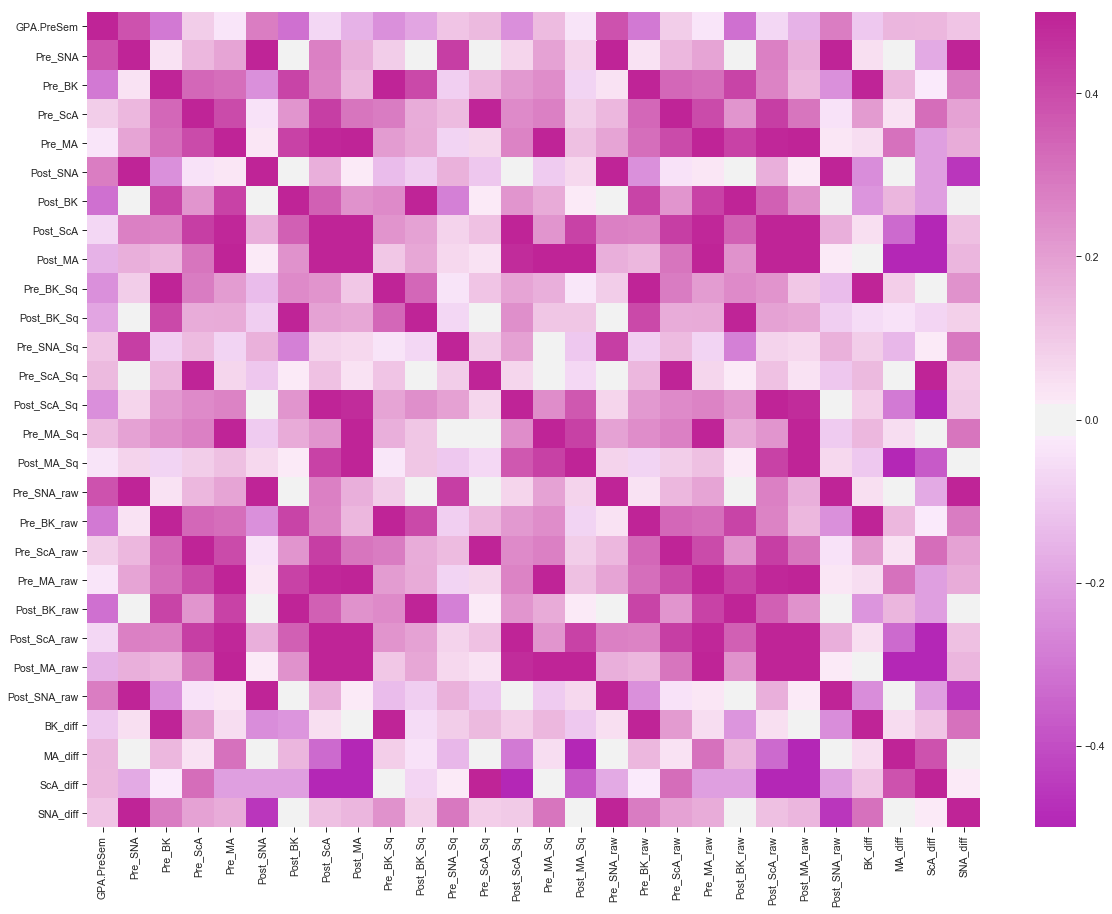

In [57]:
#excluding freshmen
f_nofresh_corr = f_nofresh.corr(method='pearson')
fig,ax = plt.subplots(figsize=(20,15))
ax = sns.heatmap(f_nofresh_corr, cmap=f, vmax=0.5, vmin=-0.5)
#fig.savefig('/Volumes/GoogleDrive/My Drive/salience-anxiety-graph-theory/figures/fig3-female-GPA_ONLY.png', dpi=300)

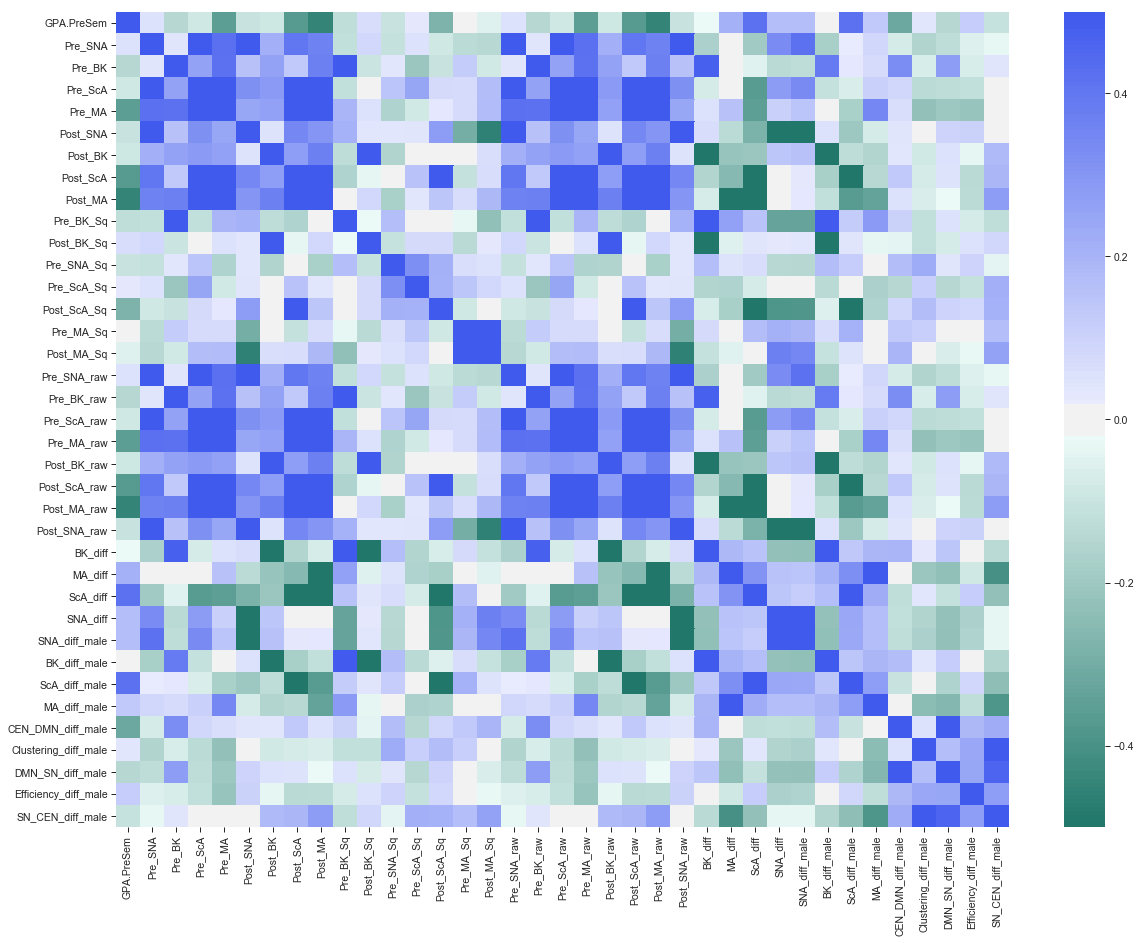

In [58]:
#excluding freshmen
m_nofresh_corr = m_nofresh.corr(method='pearson')
fig,ax = plt.subplots(figsize=(20,15))
ax = sns.heatmap(m_nofresh_corr, cmap=m, vmax=0.5, vmin=-0.5)
#fig.savefig('/Volumes/GoogleDrive/My Drive/salience-anxiety-graph-theory/figures/fig3-male-GPA_ONLY.png', dpi=300)

In [59]:
green_div = sns.diverging_palette(228.5, 137.6, s=50, l=70, n=100)
purpl_div = sns.diverging_palette(254.2, 286.1, s=70, l=56, n=100)

In [60]:
small_df = df.drop(columns=['Pre_STEMcomposite', 'Cohort', 'Post_STEMcomposite',
       'Post_CEN_DMN', 'Pre_CEN_DMN', 'Post_Clustering', 'Pre_Clustering',
       'Post_DMN_SN', 'Pre_DMN_SN', 'Post_Efficiency', 'Pre_Efficiency',
       'Post_SN_CEN', 'Pre_SN_CEN', 'Pre_BK_Sq', 'Post_BK_Sq', 'Pre_SNA_Sq',
       'Pre_ScA_Sq', 'Post_ScA_Sq', 'Pre_MA_Sq', 'Post_MA_Sq', 'Pre_SNA_raw',
       'Pre_BK_raw', 'Pre_ScA_raw', 'Pre_MA_raw', 'Post_BK_raw',
       'Post_ScA_raw', 'Post_MA_raw', 'Post_SNA_raw', 'Clustering_diff', 'Efficiency_diff',
       'filter_$', 'CEN_DMN_diff_male',
       'Clustering_diff_male', 'DMN_SN_diff_male', 'Efficiency_diff_male',
       'SN_CEN_diff_male', 'CEN_DMN_diff_female', 'Clustering_diff_female',
       'DMN_SN_diff_female', 'Efficiency_diff_female', 'SN_CEN_diff_female',
       'SNA_diff_male_raw', 'BK_diff_male_raw', 'ScA_diff_male_raw',
       'MA_diff_male_raw', 'SNA_diff_female_raw', 'BK_diff_female_raw',
       'ScA_diff_female_raw', 'MA_diff_female_raw', 'SNA_diff_male',
       'BK_diff_male', 'ScA_diff_male', 'MA_diff_male', 'AgeOnScanDate'])

In [61]:
m_df = small_df[small_df['Sex'] == 'Male']
f_df = small_df[small_df['Sex'] == 'Female']

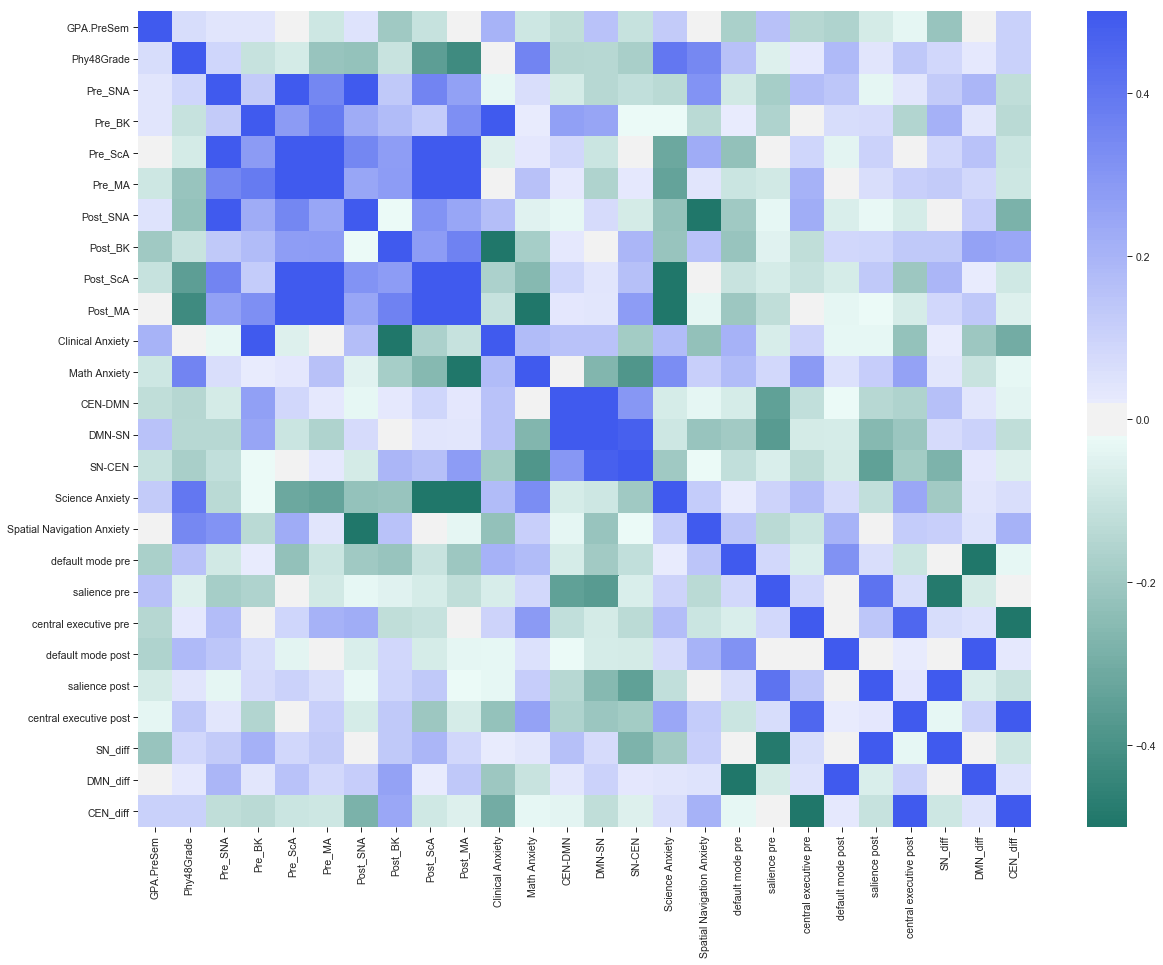

In [62]:
m_corr = m_df.corr(method='pearson')
fig,ax = plt.subplots(figsize=(20,15))
ax = sns.heatmap(m_corr, vmin=-0.5, vmax=0.5, cmap=m)
#fig.savefig('/Volumes/GoogleDrive/My Drive/salience-anxiety-graph-theory/figures/fig3-male-a.png', dpi=300)

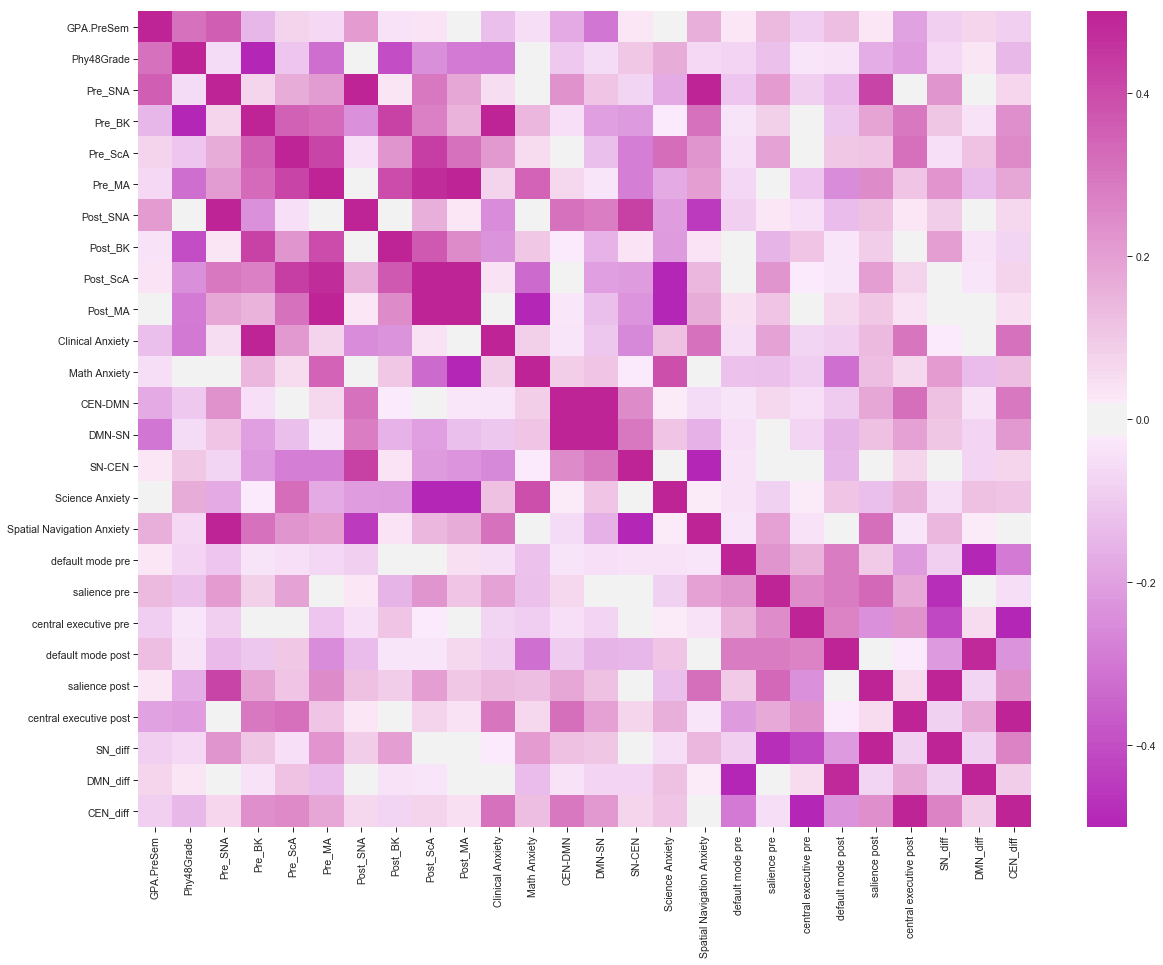

In [63]:
f_corr = f_df.corr(method='pearson')
fig,ax = plt.subplots(figsize=(20,15))
ax = sns.heatmap(f_corr, vmin=-0.5, vmax=0.5, cmap=f)
#fig.savefig('/Volumes/GoogleDrive/My Drive/salience-anxiety-graph-theory/figures/fig3-female-a.png', dpi=300)

In [64]:
f_nofresh4 = female_df_nofreshmen.drop(columns=['Physics_ID', 'Cohort', 'Gender', 'Phy48Grade',
       'AgeOnScanDate',
       'Pre_STEMcomposite',
       'Post_STEMcomposite', 'Post_Clustering',
       'Pre_Clustering', 'Post_Efficiency',
       'Pre_Efficiency', 'Clustering_diff',
       'Efficiency_diff','Pre_SNA_raw', 'Pre_BK_raw', 'Pre_ScA_raw',
       'Pre_MA_raw', 'Post_BK_raw', 'Post_ScA_raw', 'Post_MA_raw',
       'Post_SNA_raw', 'BK_diff', 'MA_diff',
       'ScA_diff', 'SNA_diff'])

In [65]:
m_nofresh4 = male_df_nofreshmen.drop(columns=['Physics_ID', 'Cohort', 'Gender', 'Phy48Grade',
       'AgeOnScanDate',
       'Pre_STEMcomposite',
       'Post_STEMcomposite', 'Post_Clustering',
       'Pre_Clustering', 'Post_Efficiency',
       'Pre_Efficiency', 'Clustering_diff',
       'Efficiency_diff','Pre_SNA_raw', 'Pre_BK_raw', 'Pre_ScA_raw',
       'Pre_MA_raw', 'Post_BK_raw', 'Post_ScA_raw', 'Post_MA_raw',
       'Post_SNA_raw', 'BK_diff', 'MA_diff',
       'ScA_diff', 'SNA_diff', 'SNA_diff_male', 'BK_diff_male', 'ScA_diff_male', 'MA_diff_male',
       'CEN_DMN_diff_male', 'Clustering_diff_male', 'DMN_SN_diff_male',
       'Efficiency_diff_male', 'SN_CEN_diff_male'])

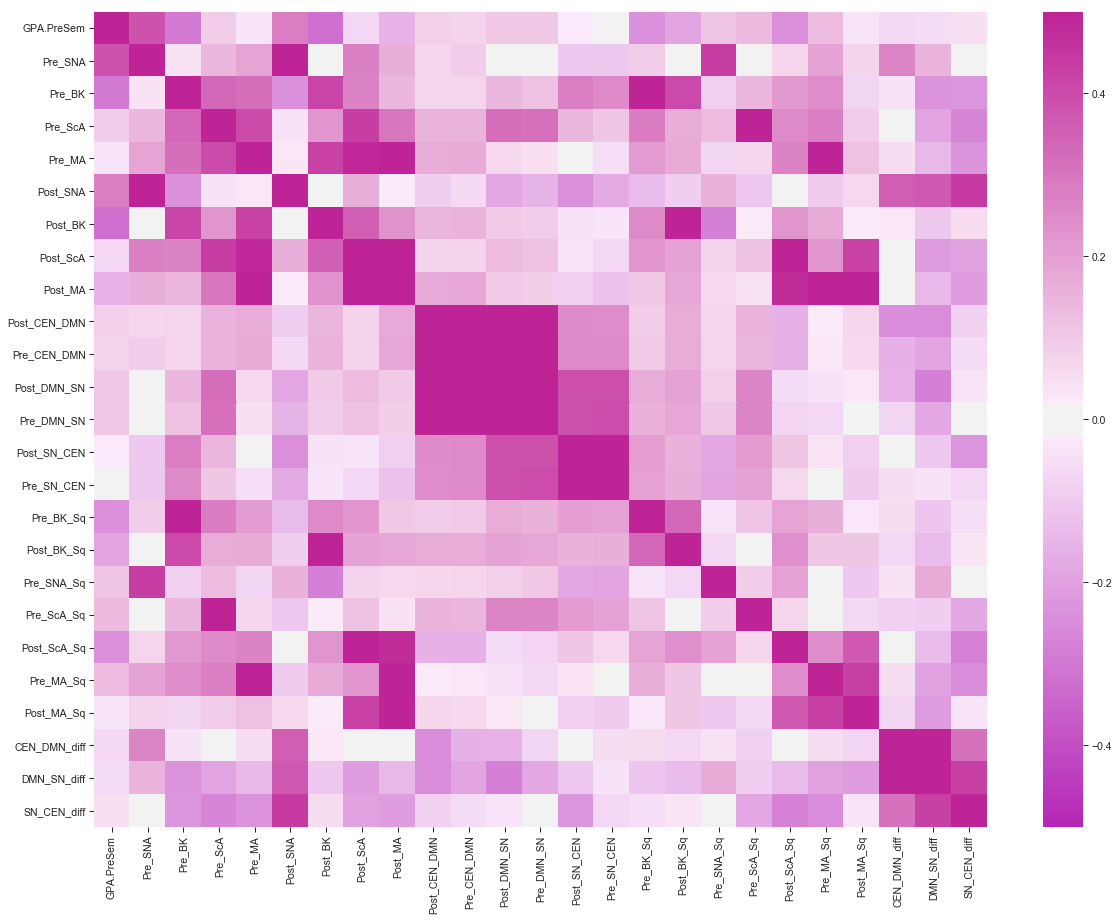

In [66]:
f_corr = f_nofresh4.corr(method='pearson')
fig,ax = plt.subplots(figsize=(20,15))
ax = sns.heatmap(f_corr, vmin=-0.5, vmax=0.5, cmap=f)
#fig.savefig('/Volumes/GoogleDrive/My Drive/salience-anxiety-graph-theory/figures/fig4-female-gpa.png', dpi=300)

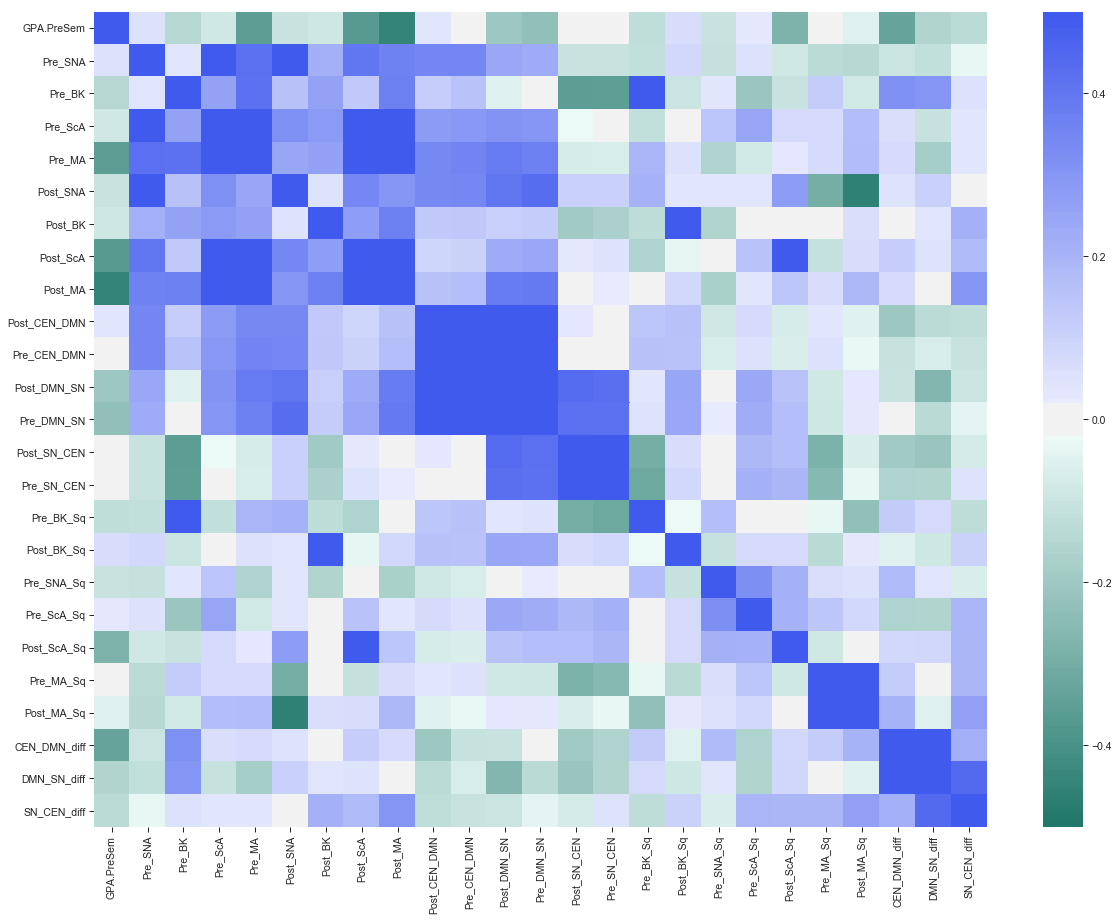

In [67]:
m_corr = m_nofresh4.corr(method='pearson')
fig,ax = plt.subplots(figsize=(20,15))
ax = sns.heatmap(m_corr, vmin=-0.5, vmax=0.5, cmap=m)
#fig.savefig('/Volumes/GoogleDrive/My Drive/salience-anxiety-graph-theory/figures/fig4-male-gpa.png', dpi=300)

In [69]:
small_df = df.drop(columns=['Pre_STEMcomposite', 'GPA.PreSem', 'Cohort', 'Post_STEMcomposite',
       'Post_Clustering', 'Pre_Clustering',
       'Post_Efficiency', 'Pre_Efficiency', 'Pre_SNA', 'Pre_BK', 'Pre_ScA',
       'Pre_MA', 'Post_SNA', 'Post_BK', 'Post_ScA', 'Post_MA', 
       'Pre_BK_Sq', 'Post_BK_Sq', 'Pre_SNA_Sq',
       'Pre_ScA_Sq', 'Post_ScA_Sq', 'Pre_MA_Sq', 'Post_MA_Sq', 'Pre_SNA_raw',
       'Pre_BK_raw', 'Pre_ScA_raw', 'Pre_MA_raw', 'Post_BK_raw',
       'Post_ScA_raw', 'Post_MA_raw', 'Post_SNA_raw', 
       'Clustering_diff', 'Efficiency_diff',
       'filter_$', 'CEN_DMN_diff_male', 
       'Clustering_diff_male', 'DMN_SN_diff_male', 'Efficiency_diff_male',
       'SN_CEN_diff_male', 'CEN_DMN_diff_female', 'Clustering_diff_female',
       'DMN_SN_diff_female', 'Efficiency_diff_female', 'SN_CEN_diff_female',
       'SNA_diff_male_raw', 'BK_diff_male_raw', 'ScA_diff_male_raw',
       'MA_diff_male_raw', 'SNA_diff_female_raw', 'BK_diff_female_raw',
       'ScA_diff_female_raw', 'MA_diff_female_raw', 'SNA_diff_male',
       'BK_diff_male', 'ScA_diff_male', 'MA_diff_male', 'AgeOnScanDate'])

In [70]:
m4_df = small_df[small_df['Sex'] == 'Male']
f4_df = small_df[small_df['Sex'] == 'Female']

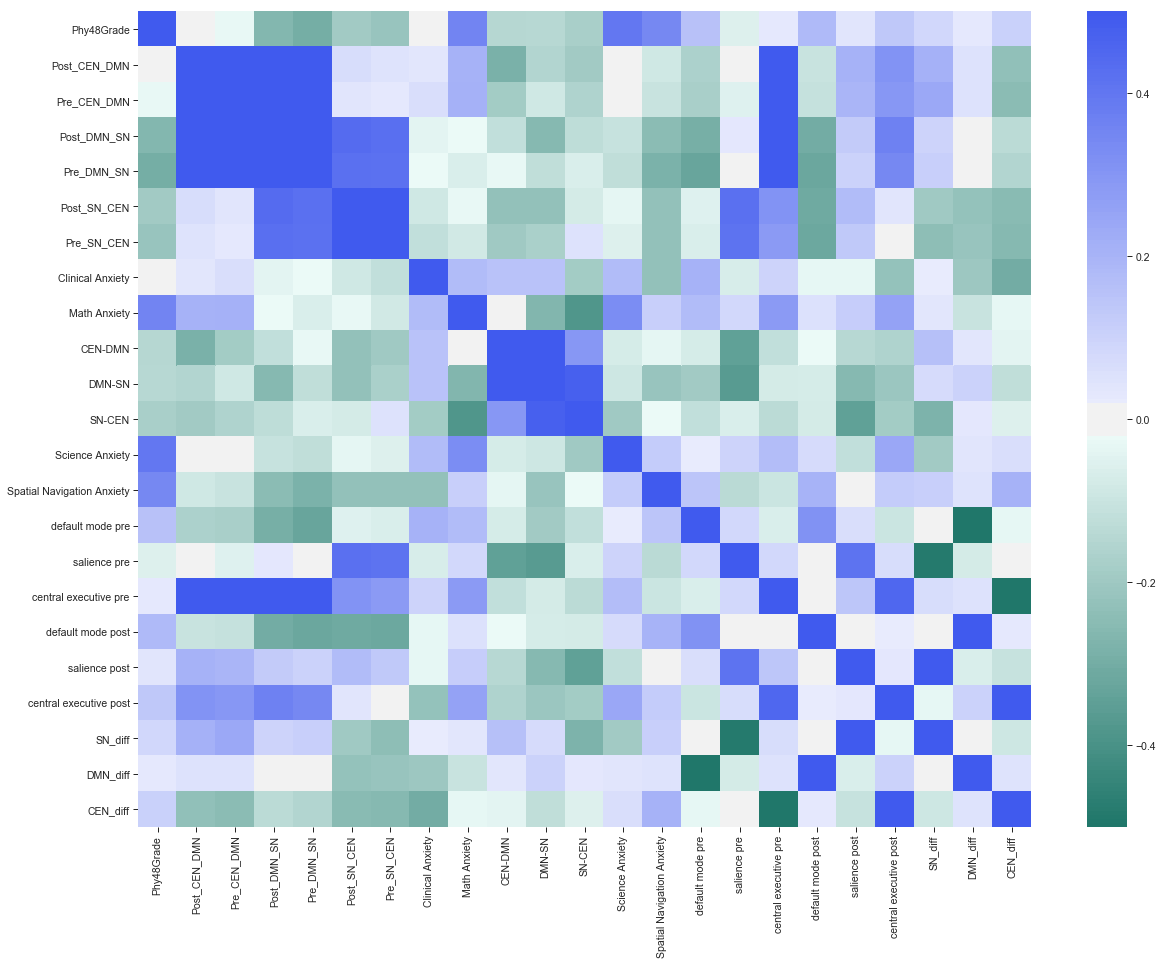

In [71]:
m_corr = m4_df.corr(method='pearson')
fig,ax = plt.subplots(figsize=(20,15))
ax = sns.heatmap(m_corr, vmin=-0.5, vmax=0.5, cmap=m)
#fig.savefig('/Volumes/GoogleDrive/My Drive/salience-anxiety-graph-theory/figures/fig4-male-grade.png', dpi=300)

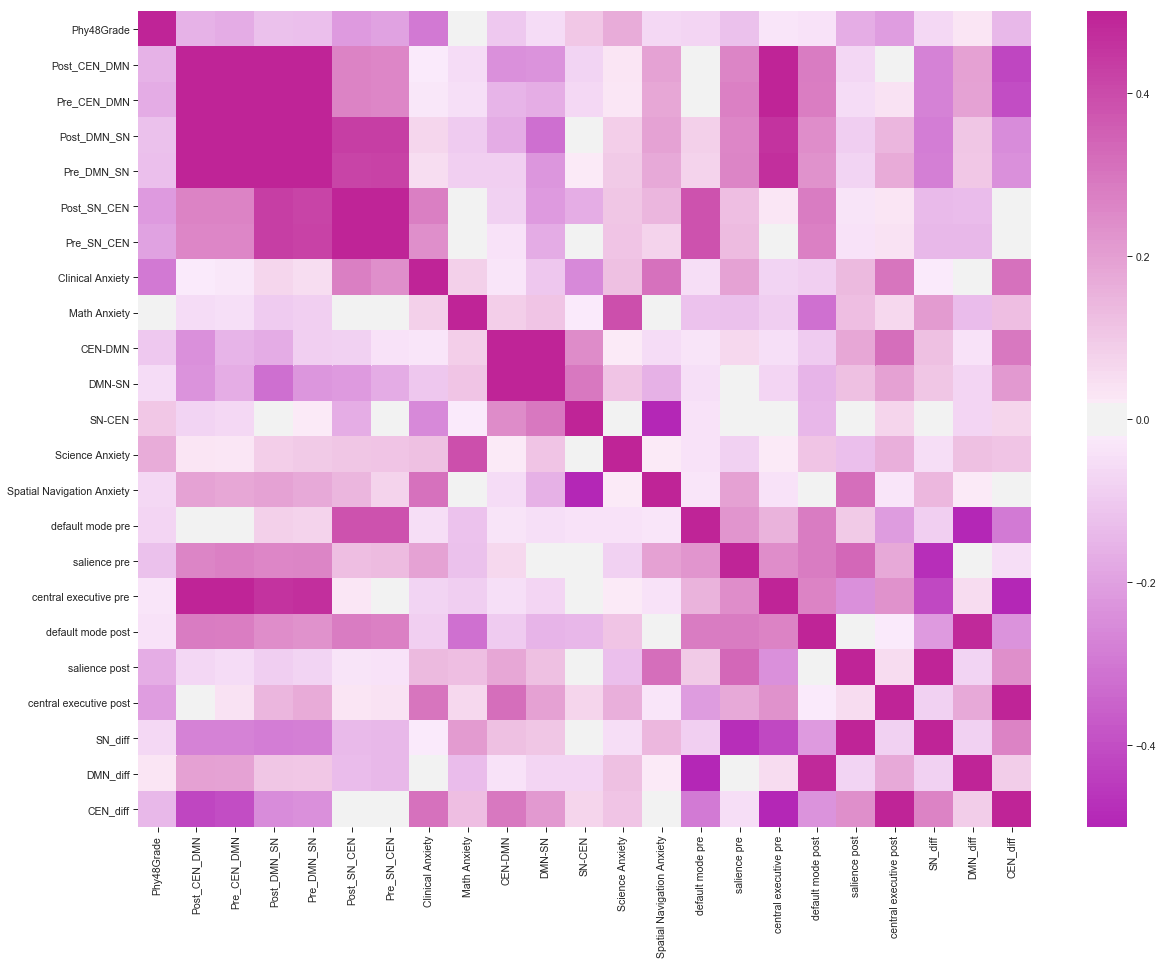

In [72]:
f_corr = f4_df.corr(method='pearson')
fig,ax = plt.subplots(figsize=(20,15))
ax = sns.heatmap(f_corr, vmin=-0.5, vmax=0.5, cmap=f)
#fig.savefig('/Volumes/GoogleDrive/My Drive/salience-anxiety-graph-theory/figures/fig4-female-grade.png', dpi=300)